In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-11-filtering-columns-date-new/__results__.html
/kaggle/input/27-11-filtering-columns-date-new/__notebook__.ipynb
/kaggle/input/27-11-filtering-columns-date-new/__output__.json
/kaggle/input/27-11-filtering-columns-date-new/custom.css
/kaggle/input/27-11-filtering-columns-date-new/full_data_to_use_27-11.csv
/kaggle/input/27-11-filtering-columns-date-new/__results___files/__results___80_0.png
/kaggle/input/27-11-filtering-columns-date-new/__results___files/__results___50_1.png
/kaggle/input/27-11-filtering-columns-date-new/__results___files/__results___9_0.png
/kaggle/input/27-11-filtering-columns-date-new/__results___files/__results___38_1.png
/kaggle/input/27-11-filtering-columns-date-new/__results___files/__results___121_1.png
/kaggle/input/27-11-filtering-columns-date-new/__results___files/__results___104_1.png
/kaggle/input/27-11-filtering-columns-date-new/__results___files/__results___84_1.png
/kaggle/input/27-11-filtering-columns-date-new/__results___files/__resul

In [2]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict


from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [3]:
from torch.nn import init
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm # , # tqdm_notebook, # tnrange
from tqdm.notebook import trange as tnrange # will change this to trange later 
from tqdm.notebook import tqdm as tqdm_notebook # will change this to tqdm later
tqdm.pandas(desc='Progress')

In [4]:
df=pd.read_csv('/kaggle/input/27-11-filtering-columns-date-new/full_data_to_use_27-11.csv')

**Only 3 year values are there, so we map them to 1,2,3**

In [5]:
new_data = { 2006:1,
             2007:2,
             2008:3}

df['booking_checkin_customer_date_year'] = df['booking_checkin_customer_date_year'].map(new_data)
df['booking_approved_at_year'] = df['booking_approved_at_year'].map(new_data)
df['booking_create_timestamp_year'] = df['booking_create_timestamp_year'].map(new_data)

In [6]:
n_features = df.shape[1]
features = list(df.columns)
features

['booking_id',
 'rating_score',
 'set',
 'booking_status',
 'country',
 'payment_type_mode',
 'payment_type_count',
 'payment_sequential_sum',
 'payment_installments_count',
 'payment_installments_sum',
 'payment_value_count',
 'booking_sequence_id_max',
 'hotel_category_max',
 'hotel_category_count',
 'hotel_name_length_mean',
 'hotel_photos_qty_mean',
 'seller_agent_id_count',
 'booking_create_timestamp_year',
 'booking_create_timestamp_month',
 'booking_create_timestamp_week',
 'booking_create_timestamp_weekday',
 'booking_create_timestamp_hour',
 'booking_approved_at_year',
 'booking_approved_at_month',
 'booking_approved_at_week',
 'booking_approved_at_weekday',
 'booking_approved_at_hour',
 'booking_checkin_customer_date_year',
 'booking_checkin_customer_date_month',
 'booking_checkin_customer_date_week',
 'booking_checkin_customer_date_weekday',
 'booking_checkin_customer_date_hour',
 'payment_value_sum_log2',
 'price_sum_log2',
 'agent_fees_sum_log2',
 'hotel_description_length

In [7]:
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

In [8]:
catf = ['booking_status',
 'country',
 'payment_type_mode',
#  'booking_sequence_id_max',
#  'hotel_category_count',
#  'seller_agent_id_count',
#  'booking_create_timestamp_year',
#  'booking_create_timestamp_month',
#  'booking_create_timestamp_week',
#  'booking_create_timestamp_weekday',
#  'booking_create_timestamp_hour',
#  'booking_approved_at_year',
#  'booking_approved_at_month',
#  'booking_approved_at_weekday',
#  'booking_checkin_customer_date_year',
#  'booking_checkin_customer_date_month',
#  'booking_checkin_customer_date_week',
#  'booking_checkin_customer_date_weekday'
       ]

cat_sz = [(c, df[c].max()+1) for c in catf]
print(cat_sz)

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

[('booking_status', 6), ('country', 9), ('payment_type_mode', 7.0)]
[(6, 3), (9, 5), (7.0, 4.0)]


In [9]:
# class PRMLDataset(Dataset):
#     def __init__(self, df, cats, y):
#         self.dfcats = df[cats]
#         self.dfconts = df.drop(cats, axis=1)
        
#         self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64)
#         self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
#         self.y = y.values.astype(np.float32)
        
#     def __len__(self): 
#         return len(self.y)

#     def __getitem__(self, idx):
#         return [self.cats[idx], self.conts[idx], self.y[idx]]
    
    
class PRMLDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

In [10]:
df.std()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


rating_score                                  1.059644
booking_status                                0.334847
country                                       2.579839
payment_type_mode                             1.274003
payment_type_count                            0.252964
payment_sequential_sum                        0.815526
payment_installments_count                    0.512525
payment_installments_sum                      2.751797
payment_value_count                           0.429139
booking_sequence_id_max                       0.518593
hotel_category_max                           22.445801
hotel_category_count                          0.531611
hotel_name_length_mean                        9.886931
hotel_photos_qty_mean                         1.730230
seller_agent_id_count                         0.532782
booking_create_timestamp_year                 0.504744
booking_create_timestamp_month                0.492870
booking_create_timestamp_week                 1.480836
booking_cr

<AxesSubplot:>

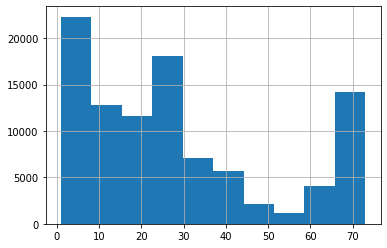

In [11]:
df['hotel_category_max'].hist()

In [12]:
train_df = df[df['set'] == 'training']
test_df = df[df['set'] == 'testing']

train_X = train_df.drop(['booking_id', 'rating_score', 'set'], axis=1)
test_X = test_df.drop(['booking_id', 'rating_score', 'set'], axis=1)


from sklearn import preprocessing
x = train_X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_X = pd.DataFrame(x_scaled, columns=train_X.columns)

test_X = pd.DataFrame(min_max_scaler.transform(test_X.values), columns=train_X.columns)


train_y = train_df['rating_score']
test_y = test_df['rating_score']


X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size = 0.20)

In [13]:
type(X_train.values)

numpy.ndarray

In [14]:
# trainds = PRMLDataset(X_train, catf, y_train)
# valds = PRMLDataset(X_val, catf, y_val)
# testds = PRMLDataset(test_X, catf, test_y)

trainds = PRMLDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.values).float())
valds = PRMLDataset(torch.from_numpy(X_val.values).float(), torch.from_numpy(y_val.values).float())
testds = PRMLDataset(torch.from_numpy(test_X.values).float(), torch.from_numpy(test_y.values).float())    

In [15]:
dataset = ConcatDataset([trainds, valds])

In [16]:
# class ConvNet(nn.Module):
#     def __init__(self,h1=96):
#         # We optimize dropout rate in a convolutional neural network.
#         super(ConvNet, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)

#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
#         self.drop1=nn.Dropout2d(p=0.5)   

#         self.fc1 = nn.Linear(32 * 7 * 7, h1)
#         self.drop2=nn.Dropout2d(p=0.1)

#         self.fc2 = nn.Linear(h1, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))

#         x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
#         x = self.drop1(x)

#         x = x.view(x.size(0),-1)

#         x = F.relu(self.fc1(x))
#         x = self.drop2(x)

#         x = self.fc2(x)

#         return x

def reset_weights(m):
    """
    Try resetting model weights to avoid weight leakage.
    """
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
#             print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()
    

# model = nn.Sequential(
#     nn.Linear(X_train.shape[1], 159),
#     nn.BatchNorm1d(159),
#     nn.ReLU(),
#     nn.Dropout(p=0.05),   
    
    
#     nn.Linear(159, 159),
#     nn.BatchNorm1d(159),
#     nn.ReLU(),
#     nn.Dropout(p=0.15),    
    
#     nn.Linear(159, 100),
#     nn.BatchNorm1d(100),
#     nn.ReLU(),
#     nn.Dropout(p=0.15), 
    
#     nn.Linear(100,1)
# )

# model = nn.Sequential(
#     nn.Linear(X_train.shape[1], 72),
#     nn.BatchNorm1d(72),
#     nn.ReLU(),
#     nn.Dropout(p=0.05),   
    
    
#     nn.Linear(72, 72),
#     nn.BatchNorm1d(72),
#     nn.ReLU(),
#     nn.Dropout(p=0.15),    
    
#     nn.Linear(72, 36),
#     nn.BatchNorm1d(36),
#     nn.ReLU(),
#     nn.Dropout(p=0.15), 
    
#     nn.Linear(36,1)
# )



model = nn.Sequential(
    nn.Linear(X_train.shape[1], 1000),
    nn.BatchNorm1d(1000),
    # nn.ReLU(),
    nn.SiLU(),
    nn.Dropout(p=0.5),   
    
    
    nn.Linear(1000, 512),
    nn.BatchNorm1d(512),
    # nn.ReLU(),
    nn.SiLU(),
    nn.Dropout(p=0.25),    
    
    nn.Linear(512,1)
)

In [17]:
from sklearn.model_selection import KFold

criterion = nn.MSELoss()

num_epochs = 70
batch_size = 5000
k = 20
splits = KFold(n_splits=k,shuffle=True,random_state=42)
foldperf = {}

In [18]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device),labels.to(device)
        # optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None
            # from pytorch documentation
            
        output = model(images)
        loss = loss_fn(output.squeeze(),labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
    
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    # print(f'reached_here')
    for images, labels in dataloader:
        # print(f'\t reached_here')

        images, labels = images.to(device),labels.to(device)
        output = model(images)
        # print(f'\t got output')
        loss = loss_fn(output.squeeze(),labels)

        # print(f'\t got loss')
        valid_loss+=loss.item()*images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()
        
    return valid_loss, val_correct


def make_preds_on_test(model, device, dataloader,loss_fn):
    sub = []
    test_dataloader = dataloader # DataLoader(testds, batch_size=batch_size, shuffle = False)

    model.eval()

    for images, labels in test_dataloader:
        images, labels = images.to(device),labels.to(device)
        output = model(images).detach().cpu().numpy()
        sub.append(output)
        
    preds = np.concatenate(sub, axis=0 )
    return preds

In [19]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
sub = []
test_dataloader = DataLoader(testds, batch_size=batch_size, shuffle = False)


for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('\nFold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
    model = model
    model.apply(reset_weights)
    model.to(device)

    # for the first 70% of epochs
    # train like 70% of epochs have lr = 0.0001
    # rest 30% have lr = 1e-6
    frac = 0.5
    lr1 = 1e-2
    lr2 = 1e-4
    
    optimizer = optim.Adam(model.parameters(), lr = lr1, weight_decay= 0.00001)
    for epoch in range(int(frac * num_epochs)):
        train_loss, train_correct = train_epoch(model,device,train_loader,criterion,optimizer)        
        val_loss, test_correct = valid_epoch(model,device,val_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        val_loss = val_loss / len(val_loader.sampler)
        if (epoch+1)%10 == 0:
            print(f"Epoch:{epoch + 1}/{num_epochs}, lr = {lr1} , AVG Training Loss:{train_loss} \t AVG Test Loss:{val_loss}")
    
    optimizer2 = optim.Adam(model.parameters(), lr = lr2, weight_decay= 0.00001)
    for epoch in range(int(frac * num_epochs), num_epochs):
        train_loss, train_correct = train_epoch(model,device,train_loader,criterion,optimizer2)        
        val_loss, test_correct = valid_epoch(model,device,val_loader,criterion)
        train_loss = train_loss / len(train_loader.sampler)
        val_loss = val_loss / len(val_loader.sampler)
        if (epoch+1)%10 == 0:
            print(f"Epoch:{epoch + 1}/{num_epochs}, lr = {lr2} , AVG Training Loss:{train_loss} \t AVG Test Loss:{val_loss}")
    
    
    preds = make_preds_on_test(model, device, test_dataloader, criterion)
    sub.append(preds)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(val_loss)


Fold 1
Epoch:10/70, lr = 0.01 , AVG Training Loss:1.5495738857670833 	 AVG Test Loss:1.4547120332717896
Epoch:20/70, lr = 0.01 , AVG Training Loss:1.5586402353487516 	 AVG Test Loss:1.4159061908721924
Epoch:30/70, lr = 0.01 , AVG Training Loss:1.4973244792536686 	 AVG Test Loss:1.5176365375518799
Epoch:40/70, lr = 0.0001 , AVG Training Loss:1.4361338740900944 	 AVG Test Loss:1.3954493999481201
Epoch:50/70, lr = 0.0001 , AVG Training Loss:1.4321022723850452 	 AVG Test Loss:1.39421808719635
Epoch:60/70, lr = 0.0001 , AVG Training Loss:1.4297340543646562 	 AVG Test Loss:1.3934084177017212
Epoch:70/70, lr = 0.0001 , AVG Training Loss:1.4293920868321468 	 AVG Test Loss:1.3939658403396606

Fold 2
Epoch:10/70, lr = 0.01 , AVG Training Loss:1.554714980878328 	 AVG Test Loss:1.4804505109786987
Epoch:20/70, lr = 0.01 , AVG Training Loss:1.4902414208964299 	 AVG Test Loss:1.424131155014038
Epoch:30/70, lr = 0.01 , AVG Training Loss:1.4576803508557772 	 AVG Test Loss:1.4282517433166504
Epoch:40/7

In [20]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])


print(f'Performance of {k} fold cross validation')
print(f"Average Training Loss: {avg_train_loss} Average Test Loss: {avg_test_loss}")  

Performance of 20 fold cross validation
Average Training Loss: 1.420085117377733 Average Test Loss: 1.3912042677402496


In [21]:
len(sub), len(sub[0])

(20, 49079)

In [22]:
type(sub[0])

numpy.ndarray

In [23]:
arr = np.array(sub).reshape(k,-1)
preds = np.mean(arr, axis = 0)
preds

array([4.105613 , 4.2706347, 4.489377 , ..., 4.216469 , 4.003313 ,
       4.532056 ], dtype=float32)

In [24]:
sample_sub = pd.read_csv('/kaggle/input/datacon-22/Processed_data/sample_submission_5.csv')
sample_sub.rating_score = preds
sample_sub.to_csv('submission_new_Archi-kfoldmodel-20_fold_finetune-loss_1_3365-1_3823.csv',index=False)

In [25]:
# # make predictions
# # note that this is like training with last k-fold wala model only

# sub = []
# test_dataloader = DataLoader(testds, batch_size=batch_size, shuffle = False)

# for images, labels in test_dataloader = DataLoader(testds, batch_size=batch_size, shuffle = False):
#     images, labels = images.to(device),labels.to(device)
#     output = model(images).detach().cpu().numpy()
#     sub.append(output)
    
# preds = np.concatenate(sub, axis=0 )
# sub = pd.read_csv('/kaggle/input/datacon-22/Processed_data/sample_submission_5.csv')
# sub.rating_score = preds
# sub.to_csv('submission_kfoldmodel-loss_1_4201-1_3958.csv',index=False)

In [26]:
# len(preds_list)